Geodesic equation for light:
$$\frac{d^2}{dt^2}x^{\lambda} = - \Gamma_{\mu\nu}^{\lambda}\frac{d}{dt}x^{\mu}\frac{d}{dt}x^{\nu}$$

To set up a differential equation for the path of light $x$, we consider the varibles: $x, \frac{dx}{dt}, \frac{d^2x}{dt^2}$

$$\begin{align*}
    \frac{d}{dt} \begin{bmatrix}
           x' \\
           x 
         \end{bmatrix}
  \end{align*}
  =
    \begin{bmatrix}
           \Gamma(x, x') \\
           x' 
         \end{bmatrix}
  $$

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phi.torch.flow import *
from tqdm import tqdm

In [ ]:
def brill_lindquist_metric(masses, positions, point):
    assert point.shape[-1] == 4, "Point must be 4D"
    _, x, y, z = point.unbind(-1)

    diffs = point[None, 1:] - positions  # (N, 3)
    r = torch.norm(diffs, dim=1)  # (N,)
    r = torch.where(r == 0, torch.tensor(1e-8, dtype=r.dtype, device=r.device), r)

    psi = 1 + torch.sum(masses / (2 * r))
    psi4 = psi ** 4

    g = torch.zeros((4, 4), dtype=point.dtype, device=point.device)
    g[0, 0] = -1.0
    g[1, 1] = psi4
    g[2, 2] = psi4
    g[3, 3] = psi4

    return g

In [ ]:
def christoffel_symbols(g, x, dx=1e-5):
    n = x.shape[0]
    G = g(x)                  
    G_inv = torch.inverse(G) 
    C = torch.zeros((n, n, n), dtype=torch.float32, device=x.device)
    dG = torch.zeros((n, n, n), dtype=torch.float32, device=x.device)

    for c in range(n):  
        with torch.no_grad():
            x_forward = x.detach().clone()
            x_backward = x.detach().clone()
            x_forward[c] += dx
            x_backward[c] -= dx
            G_plus = g(x_forward)
            G_minus = g(x_backward)
            dG[:, :, c] = (G_plus - G_minus) / (2 * dx)

    for i in range(n):
        for j in range(n):
            for k in range(n):
                sum_term = 0.0
                for l in range(n):
                    term = dG[i, l, j] + dG[j, l, i] - dG[i, j, l]
                    sum_term += G_inv[k, l] * term
                C[k, i, j] = 0.5 * sum_term

    return C

In [ ]:
masses = torch.tensor([0.7, 10.5],requires_grad=True, dtype=torch.float32).to("mps")
positions = torch.tensor([[1.0, 0.0, 0.0],
                          [-1.0, 0.0, 0.0]], dtype=torch.float32)

In [10]:
metric_func = lambda x: brill_lindquist_metric(masses, positions, x)

In [11]:
def stopping_condition(lmbda, x, v):
    if x[2] >= 3.0:
        return True
    else:
        return False

In [ ]:
# @jit_compile

def step(lmbda, x, v, dλ):
    def dv(x, v):
        C = christoffel_symbols(metric_func, x)
        return -torch.einsum('lmn,m,n->l', C, v, v)
    
    if not stopping_condition(lmbda, x, v):
    
        k1_x = v
        k1_v = dv(x, v)

        k2_x = v + 0.5 * dλ * k1_v
        k2_v = dv(x + 0.5 * dλ * k1_x, k2_x)

        k3_x = v + 0.5 * dλ * k2_v
        k3_v = dv(x + 0.5 * dλ * k2_x, k3_x)

        k4_x = v + dλ * k3_v
        k4_v = dv(x + dλ * k3_x, k4_x)

        x = x + (dλ / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        v = v + (dλ / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        lmbda = lmbda + dλ
    
    return lmbda, x, v

In [15]:
x_0 = torch.tensor([0.0, 0.9, -1.0, 0.0], dtype=torch.float32)
v_0 = torch.tensor([0.0, 0.0, 1.0, 0.0], dtype=torch.float32)
t_0 = torch.tensor(0.0, dtype=torch.double)
dt = torch.tensor(0.5, dtype=torch.float32)
t_trj, x_trj, v_trj = iterate(step, batch(time=100), t_0, x_0, v_0, dλ=.1, substeps=3)

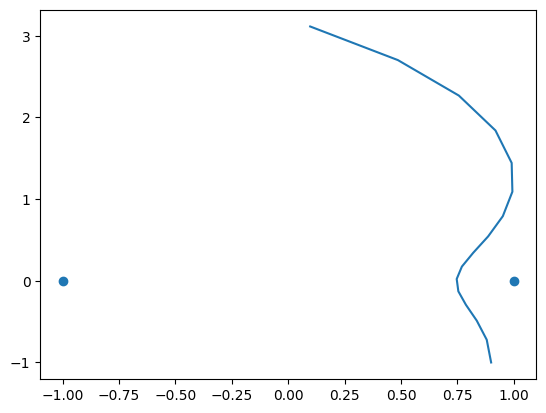

In [16]:
xy_traj = x_trj.native(['time', 'vector'])[:, 1:3]
x = []
y = []

for i in range(len(xy_traj)):
    x.append(xy_traj[i][0].detach().numpy())
    y.append(xy_traj[i][1].detach().numpy())
    
plt.plot(x, y)
plt.scatter(x=[-1, 1], y=[0, 0])

In [384]:
a = sum(x_trj.native(['time', 'vector'])[-1])
a.backward()
masses.grad

## Looking at Distorsion Image

### 2D case

In [ ]:
y_init = -3
res = 4   
x_bounds = (-3, 3)

masses = torch.tensor([0.7, 0.4],requires_grad=True, dtype=torch.float32)
positions = torch.tensor([[1.0, 0.0, 0.0],
                          [-1.0, 0.0, 0.0]], dtype=torch.float32)
metric_func = lambda x: brill_lindquist_metric(masses, positions, x)

initial_xs = []
ray_labels = []
initial_vs = []
init_x_coord = np.linspace(x_bounds[0], x_bounds[1], res)
for i in range(len(init_x_coord)):
    initial_xs.append(torch.tensor([0.0, init_x_coord[i], y_init, 0], dtype=torch.float32))
    ray_labels.append(i)
    initial_vs.append(torch.tensor([0, 0, 1, 0], dtype=torch.float32))

In [ ]:
def stopping_condition(lmbda, x, v):
    if x[2] >= 3.0:
        return True
    else:
        return False
    
# @jit_compile
def step(lmbda, x, v, dλ):
    def dv(x, v):
        C = christoffel_symbols(metric_func, x)
        return -torch.einsum('lmn,m,n->l', C, v, v)
    
    if not stopping_condition(lmbda, x, v):
        k1_x = v
        k1_v = dv(x, v)

        k2_x = v + 0.5 * dλ * k1_v
        k2_v = dv(x + 0.5 * dλ * k1_x, k2_x)

        k3_x = v + 0.5 * dλ * k2_v
        k3_v = dv(x + 0.5 * dλ * k2_x, k3_x)

        k4_x = v + dλ * k3_v
        k4_v = dv(x + dλ * k3_x, k4_x)

        x = x + (dλ / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        v = v + (dλ / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        lmbda = lmbda + dλ
    
    return lmbda, x, v

In [6]:
geodesic_info = []

for i in tqdm(range(res)):
    x_0 = initial_xs[i]
    v_0 = initial_vs[i]
    t_0 = torch.tensor(0.0, dtype=torch.double)
    dt = torch.tensor(0.5, dtype=torch.float32)
    t_trj, x_trj, v_trj = iterate(step, batch(time=100), t_0, x_0, v_0, dλ=.1, substeps=3)
    
    xy_traj = x_trj.native(['time', 'vector'])[:, 1:3]
    geodesic_info.append({"label": ray_labels[i], "xy_traj": xy_traj})

100%|█████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]


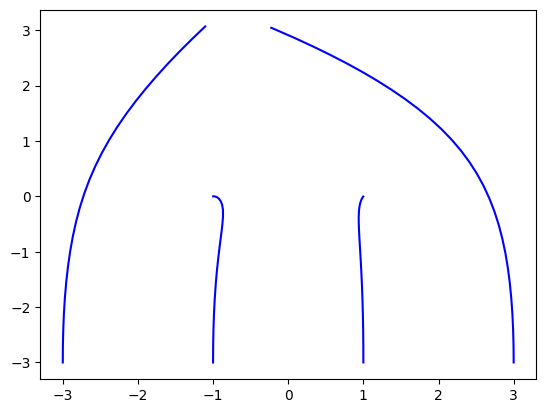

In [7]:
for info in geodesic_info:
    x = []
    y = []
    for point in info["xy_traj"]:
        x.append(point[0].detach().numpy())
        y.append(point[1].detach().numpy())
    plt.plot(x, y, 'b')
plt.show()

### 3D

In [ ]:
y_init = -3
x_bounds = (-3, 3)
z_bounds = (-3, 3)
res_x = 2  # number of rays in x-direction
res_z = 2  # number of rays in z-direction

# BH_res = 4
# positions = []
# masses = torch.rand((4 ** 3), requires_grad=True, dtype=torch.float32, device="mps")
# x_coords = np.linspace(-1, 1, BH_res)
# y_coords = np.linspace(-1, 1, BH_res)
# z_coords = np.linspace(-1, 1, BH_res)
# for i, x in enumerate(x_coords):
#     for j, y in enumerate(y_coords):
#         for k, z in enumerate(z_coords):
#             # Position in (t, x, y, z)
#             positions.append([x, y, z])

# positions = torch.tensor(positions, dtype=torch.float32).to("mps")
# metric_func = lambda x: brill_lindquist_metric(masses, positions, x)

initial_xs = []
initial_vs = []
ray_labels = []

x_coords = np.linspace(x_bounds[0], x_bounds[1], res_x)
z_coords = np.linspace(z_bounds[0], z_bounds[1], res_z)

for i, x in enumerate(x_coords):
    for j, z in enumerate(z_coords):
        # Position in (t, x, y, z)
        initial_xs.append(torch.tensor([0.0, x, y_init, z], dtype=torch.float32).to("mps"))
        # Label to track origin
        ray_labels.append((i, j))
        # Velocity in +y direction
        initial_vs.append(torch.tensor([0.0, 0.0, 1.0, 0.0], dtype=torch.float32).to("mps"))

In [ ]:
def stopping_condition(lmbda, x, v):
    if x[2] >= 3.0:
        return True
    else:
        return False
    
@jit_compile
def step(lmbda, x, v, masses, dλ):
    metric_func = lambda x: brill_lindquist_metric(masses, positions, x)
    def dv(x, v):
        C = christoffel_symbols(metric_func, x)
        return -torch.einsum('lmn,m,n->l', C, v, v)
    
    if not stopping_condition(lmbda, x, v):
        k1_x = v
        k1_v = dv(x, v)

        k2_x = v + 0.5 * dλ * k1_v
        k2_v = dv(x + 0.5 * dλ * k1_x, k2_x)

        k3_x = v + 0.5 * dλ * k2_v
        k3_v = dv(x + 0.5 * dλ * k2_x, k3_x)

        k4_x = v + dλ * k3_v
        k4_v = dv(x + dλ * k3_x, k4_x)

        x = x + (dλ / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        v = v + (dλ / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        lmbda = lmbda + dλ
    
    return lmbda, x, v, masses

In [ ]:
geodesic_info = []
endpoint_list = [] 

for idx in tqdm(range(len(initial_xs))):
    x_0 = initial_xs[idx]
    v_0 = initial_vs[idx]
    label = ray_labels[idx]

    t_0 = torch.tensor(0.0, dtype=torch.float32).to("mps")
    dt = torch.tensor(0.5, dtype=torch.float32).to("mps")

    t_trj, x_trj, v_trj, masses_dyn = iterate(step, batch(time=100), t_0, x_0, v_0, masses, dλ=0.1, substeps=3)
    xz_traj = x_trj.native(['time', 'vector'])[:, [1, 3]]

    geodesic_info.append({
        "label": label,
        "xz_traj": xz_traj  
    })
    endpoint_list.append(x_trj.native(['time', 'vector'])[-1])
    
endpoints = torch.stack(endpoint_list).reshape(res_x, res_z, 4)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fengqijie/miniconda3/envs/pytorch2.6/lib/python3.12/site-packages/phiml/backend/torch/_torch_backend.py:1161: RuntimeWarning: PyTorch does not support nested tracing. The inner JIT of native(step) will be ignored.
  warnings.warn(f"PyTorch does not support nested tracing. The inner JIT of {self.f.__name__} will be ignored.", RuntimeWarning)
100%|█████████████████████████████████████████████| 4/4 [04:06<00:00, 61.68s/it]


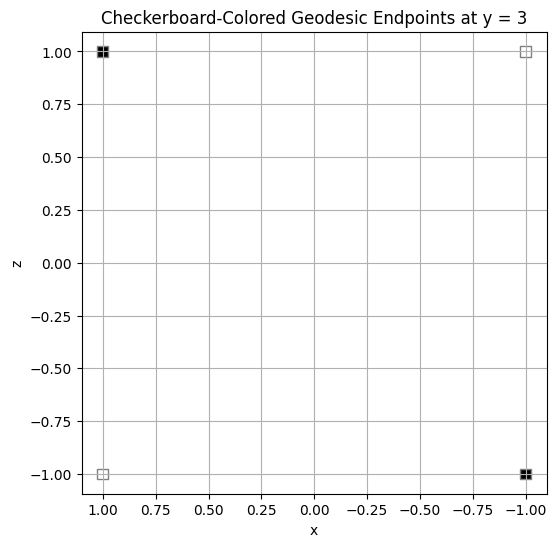

In [ ]:
endpoints_x = []
endpoints_z = []
colors = []

for info in geodesic_info:
    traj = info["xz_traj"]
    i, j = info["label"]  

    if traj.shape[0] > 0 and traj[-1].shape[0] == 2:
        x_end, z_end = traj[-1]

        endpoints_x.append(x_end.item())
        endpoints_z.append(z_end.item())

        color = 'black' if (i + j) % 2 == 0 else 'white'
        colors.append(color)

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(endpoints_x, endpoints_z, c=colors, edgecolors='gray', s=60, marker='s')
plt.xlabel("x")
plt.ylabel("z")
plt.title("Checkerboard-Colored Geodesic Endpoints at y = 3")
plt.gca().invert_xaxis() 
plt.grid(True)
plt.axis('equal')
plt.show()

In [189]:
def loss(yhat, y):
    l = yhat - y
    return torch.sum(torch.square(l))

In [ ]:
y = []

for i, x in enumerate(x_coords):
    row = []
    for j, z in enumerate(z_coords):
        row.append([0.0, x, 3, z])
    y.append(row)

y = torch.tensor(y, dtype=torch.float32).to("mps")

In [191]:
l = loss(endpoints, y)
l.backward()

In [192]:
masses.grad

tensor([ -552.7974,  -605.1693,  -658.7933,  -708.1059,  -545.2014,  -597.2939,
         -649.9116,  -697.3511,  -526.5190,  -578.8962,  -627.2355,  -667.2662,
         -509.8328,  -553.4512,  -595.4079,  -631.5607,  -605.9376,  -677.0290,
         -755.3245,  -833.0412,  -597.9800,  -668.2120,  -745.7943,  -822.3937,
         -579.5247,  -644.5401,  -715.3030,  -783.9909,  -554.0530,  -610.4362,
         -669.7061,  -725.4221,  -660.5104,  -756.2065,  -871.4146,  -998.7087,
         -651.3345,  -746.3036,  -862.8799,  -993.7491,  -628.6435,  -716.1002,
         -821.0396,  -938.7244,  -596.9068,  -670.6650,  -755.4072,  -843.1559,
         -711.0355,  -835.0142,  -999.8521, -1210.6924,  -699.7258,  -824.1157,
         -994.9732, -1232.0128,  -664.1432,  -785.5826,  -939.8525, -1022.2258,
         -633.9169,  -727.0833,  -844.1275,  -985.7214], device='mps:0')

In [ ]:
with torch.no_grad():
    masses -= 3.0 * masses.grad 

In [158]:
if masses.grad is not None:
    masses.grad.zero_()

## Optimization Loop

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from phi.torch.flow import *
from tqdm import tqdm


def stopping_condition(lmbda, x, v):
    if x[2] >= 1.0:      
        return True
    else:
        return False
    
# @jit_compile
def step(lmbda, x, v, masses, dλ):
    metric_func = lambda x: brill_lindquist_metric(masses, positions, x)
    def dv(x, v):
        C = christoffel_symbols(metric_func, x)
        return -torch.einsum('lmn,m,n->l', C, v, v)
    
    if not stopping_condition(lmbda, x, v):
    
        k1_x = v
        k1_v = dv(x, v)

        k2_x = v + 0.5 * dλ * k1_v
        k2_v = dv(x + 0.5 * dλ * k1_x, k2_x)

        k3_x = v + 0.5 * dλ * k2_v
        k3_v = dv(x + 0.5 * dλ * k2_x, k3_x)

        k4_x = v + dλ * k3_v
        k4_v = dv(x + dλ * k3_x, k4_x)
        x = x + (dλ / 6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        v = v + (dλ / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        lmbda = lmbda + dλ
    
    return lmbda, x, v, masses



def forward(initial_xs, initial_vs, masses):
    endpoint_list = [] 
    for idx in tqdm(range(len(initial_xs))):
        x_0 = initial_xs[idx]
        v_0 = initial_vs[idx]

        t_0 = torch.tensor(0.0, dtype=torch.float32).to("mps")
        dt = torch.tensor(0.5, dtype=torch.float32).to("mps")

        t_trj, x_trj, v_trj, masses_dyn = iterate(step, batch(time=50), t_0, x_0, v_0, masses, dλ=0.3, substeps=3)

        endpoint_list.append(x_trj.native(['time', 'vector'])[-1])

    endpoints = torch.stack(endpoint_list).reshape(res_x, res_z, 4)
    
    return endpoints


def loss(yhat, y):
    l = yhat - y
    return torch.sum(torch.square(l))


In [ ]:
y_init = -3
x_bounds = (-3, 3)
z_bounds = (-3, 3)
res_x = 2  
res_z = 2  

# black hole configuration
BH_res = 4
positions = []
masses = torch.rand((4 ** 3), requires_grad=True, dtype=torch.float32, device="mps")
x_coords = np.linspace(-1, 1, BH_res)
y_coords = np.linspace(-1, 1, BH_res)
z_coords = np.linspace(-1, 1, BH_res)
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            positions.append([x, y, z])

positions = torch.tensor(positions, dtype=torch.float32).to("mps")
# metric_func = lambda x: brill_lindquist_metric(masses, positions, x)

initial_xs = []
initial_vs = []
ray_labels = []

x_coords = np.linspace(x_bounds[0], x_bounds[1], res_x)
z_coords = np.linspace(z_bounds[0], z_bounds[1], res_z)

for i, x in enumerate(x_coords):
    for j, z in enumerate(z_coords):
        # Position in (t, x, y, z)
        initial_xs.append(torch.tensor([0.0, x, y_init, z], dtype=torch.float32).to("mps"))
        # Label to track origin
        ray_labels.append((i, j))
        # Velocity in +y direction
        initial_vs.append(torch.tensor([0.0, 0.0, 1.0, 0.0], dtype=torch.float32).to("mps"))
        
y = []
for i, x in enumerate(x_coords):
    row = []
    for j, z in enumerate(z_coords):
        row.append([0.0, x, 3, z])
    y.append(row)
y = torch.tensor(y, dtype=torch.float32).to("mps")

In [32]:
optimizer = torch.optim.Adam([masses], lr=1e-1)


for epoch in range(100):
    optimizer.zero_grad()              
    endpoints = forward(initial_xs=initial_xs, initial_vs=initial_vs, masses=masses)
    l = loss(endpoints, y)
    l.backward()
    optimizer.step()
    print(f"Loss = {l.item():.6f}")

  0%|                                                     | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: 

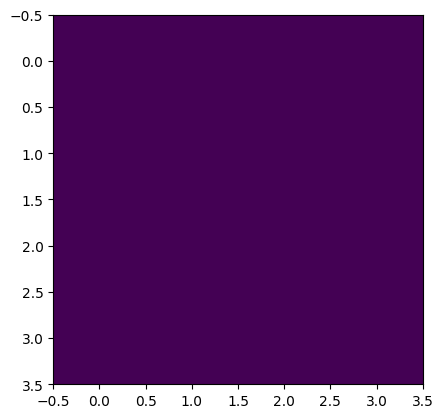

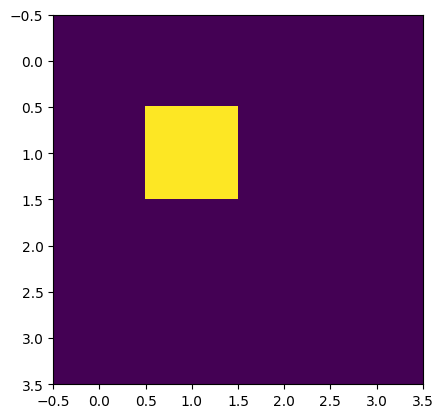

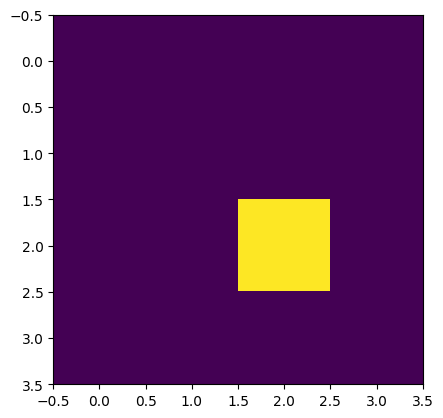

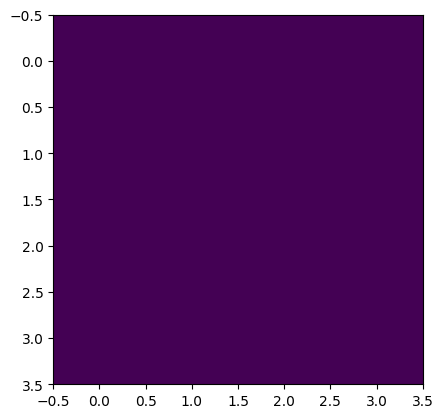

In [286]:
masses_reshaped = masses.cpu().detach().numpy().reshape((4, 4, 4))
masses_swapped = np.swapaxes(masses_reshaped, 1, 2)
for i in range(4):
    plt.imshow(masses_reshaped[i])
    plt.show()

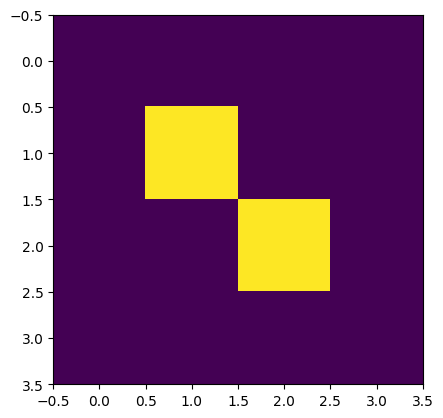

In [287]:
masses_summed = np.zeros((4, 4))
for i in range(4):
    masses_summed += masses_reshaped[i]
    
plt.imshow(masses_summed)

In [ ]:
from PIL import Image
import numpy as np

img = Image.open('webb.png').convert('RGB') 
img = np.array(img)

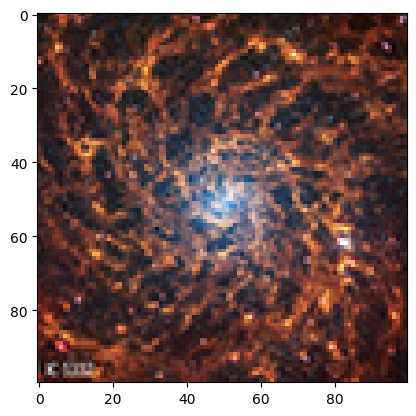

In [3]:
plt.imshow(img)

In [240]:
np.save("zoomed.npy", center_crop)

# Apply black hole transform to image

In [95]:
img = Image.open('webb200x200.png').convert('RGB')
img = np.array(img)

In [ ]:
# img = np.load("spiral_galaxy.npy")
res_x, res_z, _ = img.shape

y_init = -1
x_bounds = (-0.5, 0.5)
z_bounds = (-0.5, 0.5)

BH_res = 4
positions = []
M = 0.01
# masses = torch.zeros((BH_res, BH_res, BH_res), dtype=torch.float32)  # or flatten it later

# corner1 = (1, 1, 1)
# corner2 = (2, 2, 2)

# masses[corner1] = M
# masses[corner2] = M
masses = [np.float32(-0.0014755036), np.float32(-0.0016611572), np.float32(-0.0001455406), np.float32(0.0014496766), np.float32(-0.00028761008), np.float32(0.0005209246), np.float32(0.0035427874), np.float32(0.0049434016), np.float32(0.0038887456), np.float32(0.004752997), np.float32(0.006611966), np.float32(0.0073616933), np.float32(0.007928553), np.float32(0.009817303), np.float32(0.010284435), np.float32(0.009563326), np.float32(-0.0026129473), np.float32(-0.00395948), np.float32(-0.0023292422), np.float32(-0.00038730123), np.float32(-0.0018078022), np.float32(0.008191748), np.float32(0.0034316585), np.float32(0.005363337), np.float32(0.004197401), np.float32(0.004941364), np.float32(0.0073401122), np.float32(0.008193018), np.float32(0.009789553), np.float32(0.015182523), np.float32(0.0127173215), np.float32(0.010810168), np.float32(-0.00022433698), np.float32(-0.0026664946), np.float32(-0.0013908076), np.float32(-0.0005227485), np.float32(0.0030589816), np.float32(1.8073866e-05), np.float32(0.0005325495), np.float32(0.0051021334), np.float32(0.007085294), np.float32(0.0060992255), np.float32(0.013077466), np.float32(0.0055814655), np.float32(0.0108455485), np.float32(0.011855699), np.float32(0.005262816), np.float32(0.008950412), np.float32(0.0013250891), np.float32(-0.00047963858), np.float32(-0.00078247057), np.float32(0.0006367592), np.float32(0.0050970055), np.float32(0.0047432315), np.float32(0.004637174), np.float32(0.0053917128), np.float32(0.00771775), np.float32(0.007444127), np.float32(0.0062292344), np.float32(0.0065216008), np.float32(0.009685055), np.float32(0.00977661), np.float32(0.008547153), np.float32(0.008192964)]
masses = torch.tensor(masses, dtype=torch.float32)

masses = masses.flatten()
# masses = torch.zeros((4 ** 3), dtype=torch.float32)
x_coords = np.linspace(-0.5, 0.5, BH_res)
y_coords = np.linspace(-0.5, 0.5, BH_res)
z_coords = np.linspace(-0.5, 0.5, BH_res)   
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            positions.append([x, y, z])

positions = torch.tensor(positions, dtype=torch.float32)
# metric_func = lambda x: brill_lindquist_metric(masses, positions, x)

initial_xs = []
initial_vs = []
ray_labels = []

x_coords = np.linspace(x_bounds[0], x_bounds[1], res_x)
z_coords = np.linspace(z_bounds[1], z_bounds[0], res_z)
        
initial_xs = torch.zeros((res_z, res_x, 4), dtype=torch.float32)
initial_vs = torch.zeros((res_z, res_x, 4), dtype=torch.float32)
for h, z in enumerate(z_coords):
    for w, x in enumerate(x_coords):
        # Position in (t, x, y, z)
        initial_xs[h][w] = torch.tensor([0.0, x, y_init, z], dtype=torch.float32)
        # Label to track origin
        ray_labels.append((w, h))
        # Velocity in +y direction
        initial_vs[h][w] = torch.tensor([0.0, 0.0, 1.0, 0.0], dtype=torch.float32)
initial_xs = initial_xs.reshape((-1, 4))
initial_vs = initial_vs.reshape((-1, 4))
colors = img.reshape((-1, 3))

In [ ]:
geodesic_info = []
endpoint_list = []

for idx in tqdm(range(len(initial_xs))):
    x_0 = initial_xs[idx]
    v_0 = initial_vs[idx]
    label = ray_labels[idx]
    color = colors[idx] / 255.0

    t_0 = torch.tensor(0.0, dtype=torch.float32)
    dt = torch.tensor(0.5, dtype=torch.float32)

    t_trj, x_trj, v_trj, masses_dyn = iterate(step, batch(time=50), t_0, x_0, v_0, masses, dλ=0.3, substeps=3)
    xyz_traj = x_trj.native(['time', 'vector'])[:, [1, 2, 3]]

    geodesic_info.append({
        "label": label,
        "xyz_traj": xyz_traj, 
        'color': color
    })
    endpoint_list.append(x_trj.native(['time', 'vector'])[-1])
    
# endpoints = torch.stack(endpoint_list).reshape(res_x, res_z, 4)

100%|███████████████████████████████████| 40000/40000 [1:24:08<00:00,  7.92it/s]


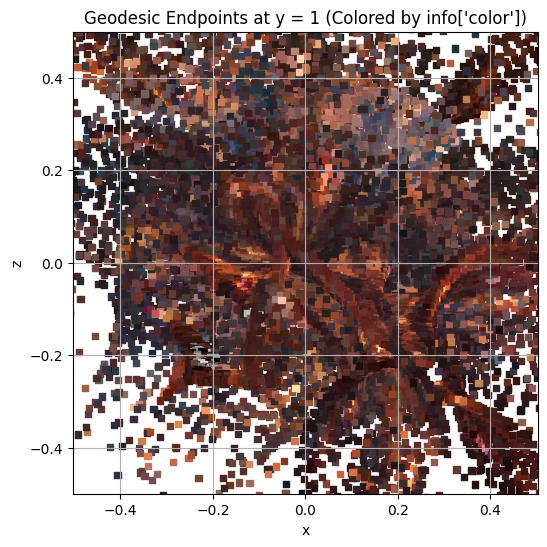

In [ ]:
from matplotlib.colors import to_rgb

endpoints_x = []
endpoints_z = []
colors = []


for info in geodesic_info:
    traj = info["xyz_traj"]
    if traj.shape[0] > 0 and traj[-1].shape[0] == 3 and traj[-1][1] >= 1.0:
        traj = traj[:, [0, 2]]
        
        x_end, z_end = traj[-1]
        rgb = to_rgb(info["color"]) 
        endpoints_x.append(x_end.item())
        endpoints_z.append(z_end.item())
        colors.append(info['color'])

        

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(endpoints_x, endpoints_z, c=colors, s=20, marker='s')
plt.xlabel("x")
plt.ylabel("z")
plt.title("Geodesic Endpoints at y = 1 (Colored by info['color'])")
plt.grid(True)
plt.axis('equal')
plt.xlim(x_min, x_max)
plt.ylim(z_min, z_max)
plt.show()

### Interpolation

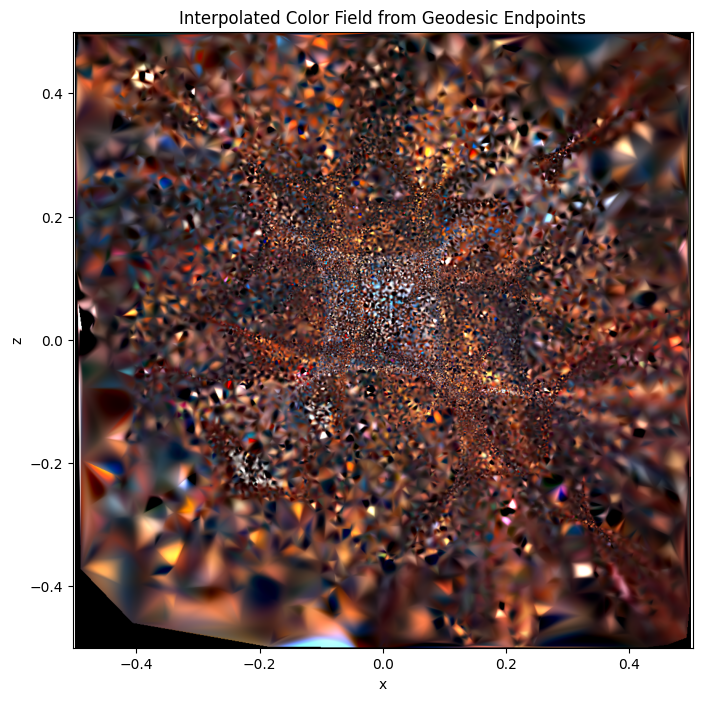

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import to_rgb
from scipy.spatial import cKDTree

points = []
colors_rgb = []

for info in geodesic_info:
    traj = info["xyz_traj"]
    if traj.shape[0] > 0 and traj[-1].shape[0] == 3 and traj[-1][1] >= 1.0:
        traj = traj[:, [0, 2]]
        
        x_end, z_end = traj[-1]
        rgb = to_rgb(info["color"]) 
        points.append([x_end.item(), z_end.item()])
        colors_rgb.append(rgb)

x_min_bound, x_max_bound = -0.5, 0.5
z_min_bound, z_max_bound = -0.5, 0.5

points = np.array(points)
colors_rgb = np.array(colors_rgb)

mask = (
    (points[:, 0] >= x_min_bound) & (points[:, 0] <= x_max_bound) &
    (points[:, 1] >= z_min_bound) & (points[:, 1] <= z_max_bound)
)

points = points[mask]
colors_rgb = colors_rgb[mask]

grid_res = 1000  
x_min, x_max = points[:, 0].min(), points[:, 0].max()
z_min, z_max = points[:, 1].min(), points[:, 1].max()

grid_x, grid_z = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(z_min, z_max, grid_res)
)

grid_r = griddata(points, colors_rgb[:, 0], (grid_x, grid_z), method='cubic', fill_value=0)
grid_g = griddata(points, colors_rgb[:, 1], (grid_x, grid_z), method='cubic', fill_value=0)
grid_b = griddata(points, colors_rgb[:, 2], (grid_x, grid_z), method='cubic', fill_value=0)

color_field = np.stack([grid_r, grid_g, grid_b], axis=-1)  # [H, W, 3]

color_field = np.clip(color_field, 0, 1)

max_dist = 0.1  

tree = cKDTree(points)

grid_points = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)  
dists, _ = tree.query(grid_points)

dist_grid = dists.reshape(grid_x.shape)

mask_far = dist_grid > max_dist
color_field[mask_far] = 0.0  


plt.figure(figsize=(8, 8))
plt.imshow(color_field, extent=(x_min, x_max, z_min, z_max), origin='lower')
plt.xlabel('x')
plt.ylabel('z')
plt.title("Interpolated Color Field from Geodesic Endpoints")
# circle1 = plt.Circle((-0.1329, -0.1344), 0.02, color='r')
# plt.gca().add_patch(circle1)
plt.axis('equal')
plt.show()

In [81]:
ys = []
coords = [(69, 11), (22, 85), (79, 90), (51, 52), (29, 16), (65, 41), (52, 77)]
for characteristic_point in coords:
    for info in geodesic_info:
        if info['label'] == (characteristic_point[0]*2, characteristic_point[1]*2):
            print(characteristic_point, "------>", info['xyz_traj'][0])
            ys.append(info['xyz_traj'][-1].numpy()[[0, 2]])

(69, 11) ------> tensor([ 0.1935, -1.0000,  0.3894])
(22, 85) ------> tensor([-0.2789, -1.0000, -0.3543])
(79, 90) ------> tensor([ 0.2940, -1.0000, -0.4045])
(51, 52) ------> tensor([ 0.0126, -1.0000, -0.0226])
(29, 16) ------> tensor([-0.2085, -1.0000,  0.3392])
(65, 41) ------> tensor([ 0.1533, -1.0000,  0.0879])
(52, 77) ------> tensor([ 0.0226, -1.0000, -0.2739])


In [179]:
np.save("y.npy", y)

In [391]:
geodesic_info = np.array([geodesic_info])
np.save("geodesic_info.npy", geodesic_info)

In [392]:
info = np.load("geodesic_info.npy", allow_pickle=True)

## Characteristic points

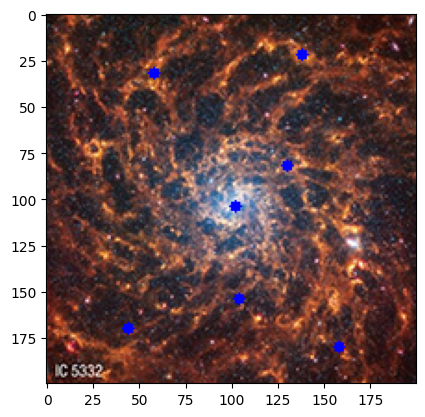

In [ ]:
from PIL import Image
import numpy as np

img = Image.open('webb200x200.png').convert('RGB')  
img = np.array(img)  

coords = [(69, 11), (22, 85), (79, 90), (51, 52), (29, 16), (65, 41), (52, 77)]
radius = 3  
H, W, _ = img.shape
for x0, y0 in coords:
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dx**2 + dy**2 <= radius**2:
                x, y = x0*2 + dx, y0*2 + dy
                if 0 <= x < W and 0 <= y < H:
                    img[y, x] = [0, 0, 255]  

plt.imshow(img)

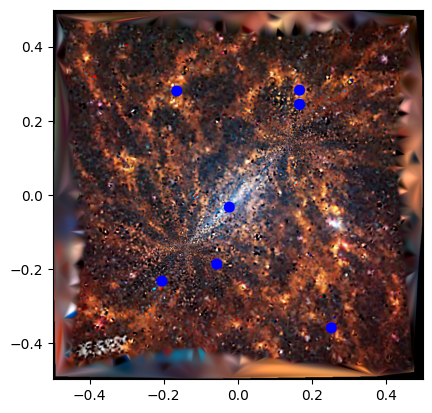

In [ ]:
from PIL import Image
import numpy as np

color_field_copy = color_field.copy()

coords = [np.array(np.round((coord + 0.5) * 500), dtype=int) for coord in ys]
radius = 15  
H, W, _ = color_field_copy.shape
for x0, y0 in coords:
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dx**2 + dy**2 <= radius**2:
                x, y = x0*2 + dx, y0*2 + dy
                if 0 <= x < W and 0 <= y < H:
                    color_field_copy[y, x] = [0, 0, 1] 

plt.imshow(color_field_copy, extent=(x_min, x_max, z_min, z_max), origin='lower')

In [76]:
[list(coord) for coord in ys]

[[np.float32(0.16694818), np.float32(0.28072944)],
 [np.float32(-0.20667507), np.float32(-0.23620655)],
 [np.float32(0.25112817), np.float32(-0.36125812)],
 [np.float32(-0.024412729), np.float32(-0.035667002)],
 [np.float32(-0.16540128), np.float32(0.27825055)],
 [np.float32(0.1669375), np.float32(0.24258697)],
 [np.float32(-0.05863329), np.float32(-0.19011398)]]